Earthquakes

In [9]:
#Run this first
import obspy
import numpy as np
from obspy.clients.fdsn.client import Client
 ##TODOli Can't install cartopy on Noah's local machine
import pandas as pd
import geopandas as gpd
from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc
from matplotlib import pyplot as plt

In [10]:
#run this cell to define functions

def quakeML_Loader(filepath): #Loads quakeML file formats as Catalog
    # Make an obspy Catalog object from the QuakeML file.
    return obspy.core.event.read_events(filepath)
    #Copied from Maleen's code
    #Not sure this 1-line function actually needs to exist

def generate_summary(cat): #function that generates a summary table of data from a catalog of events for identification of best candidate events
    resource_ids = []
    magnitudes = []
    pick_counts =[]
    epi_lats = []
    epi_longs = []
    times = []
    depths = []
    for event in cat:
        resource_ids.append(event.resource_id)
        magnitudes.append(event.magnitudes[0].mag)
        pick_counts.append(len(event.picks))
        epi_lats.append(event.origins[0].latitude)
        epi_longs.append(event.origins[0].longitude)
        times.append(event.origins[0].time)
        depths.append(event.origins[0].depth)
    summary = pd.DataFrame(resource_ids, magnitudes).reset_index()
    summary.columns = ['magnitudes','resource_ids']
    summary['pick_counts'] = pick_counts #unsure why this needs to be done on its own but it works
    summary['epi_lats'] = epi_lats
    summary['epi_longs'] = epi_longs
    summary['times'] = times
    summary['depths'] = depths
    #these two lines can be edited for legibility and helpfulness
    print('Biggest earthquake was', summary.sort_values(by='magnitudes', ascending = False).get('resource_ids').iloc[0],'with magnitude',str(summary.sort_values(by='magnitudes', ascending = False).get('magnitudes').iloc[0])+'.')
    print('Best picked earthquake was', summary.sort_values(by='pick_counts', ascending = False).get('resource_ids').iloc[0],'with',summary.sort_values(by='pick_counts', ascending = False).get('pick_counts').iloc[0],'picks.')
    #TODO get index position(s) of most relevant quakes, but for our data set it's i = 170
    return summary

def quakeML_Reader(event):
    epicenter = (event.origins[0].latitude, event.origins[0].longitude) #stores event epicenter lat/lon as tuple
    magnitude = event.magnitudes[0].mag #stores event magnitude
    birthday = event.origins[0].time #stores time at which event occurs
    results = []
    for arrival in event.origins[0].arrivals: #goes through arrival data and notes phase, azimuthal angle, distance from epicenter and pick_id in 2D list
        phase = arrival.phase
        azi = arrival.azimuth
        dist = arrival.distance * 111 #there is a note in Maleen's code about this being in degrees
        pick_id = arrival.pick_id
        result = [phase, azi, dist, pick_id]
        results.append(result)
    arrivals = pd.DataFrame(results)
    arrivals.columns = ['phase','azimuth','distance','pick_id'] #makes DataFrame of arrivals data
    results = []
    for pick in event.picks: #goes through pick data and notes time of arrival, station data and pick_id in 2D list
        pick_id = pick.resource_id
        time = pick.time
        network_code = pick.waveform_id.network_code
        station_code = pick.waveform_id.station_code
        channel_code =pick.waveform_id.channel_code
        result = [pick_id, time, network_code, station_code, channel_code]
        results.append(result)
    picks = pd.DataFrame(results)
    picks.columns = ['pick_id','time','network_code','station_code','channel_code'] #makes DataFrame of picks data
    picks['travel_time'] = picks['time'] - birthday
    log = arrivals.merge(picks, left_on='pick_id', right_on='pick_id').sort_values(by='travel_time') #merges arrivals and picks data
    log['velocity'] = log['distance'] / log['travel_time']
    bonus = (epicenter, magnitude, birthday) #TODO integrate bonus

    #adds lat lon to picks
    #code borrowed from Zoe's explore_data.ipynb
    sta_list = np.unique(log.station_code)

    # Get all the info for those stations from IRIS
    network = ",".join((np.unique(log.network_code)).tolist())
    channel = ",".join((np.unique(log.channel_code)).tolist())
    station = ",".join((np.unique(log.station_code)).tolist())

    starttime = np.min(log['time'])
    endtime = np.max(log['time'])

    sta_metadata = Client("iris").get_stations(starttime=starttime,endtime=endtime,network=network,channel=channel,station=station,location='',level='response')

    station_locs = defaultdict(dict)
    for network in sta_metadata:
        for station in network:
            for chn in station:
                sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}" + chn.start_date.strftime('%Y%j')
                if sid in station_locs:
                    station_locs[sid]["component"] += f",{chn.code[-1]}"
                    station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
                else:
                    component = f"{chn.code[-1]}"
                    response = f"{chn.response.instrument_sensitivity.value:.2f}"
                    dtype = chn.response.instrument_sensitivity.input_units.lower()
                    tmp_dict = {}
                    tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                        chn.longitude,
                        chn.latitude,
                        chn.elevation,
                    )
                    tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                    tmp_dict["start_date"], tmp_dict["end_date"] = chn.start_date,chn.end_date
                    tmp_dict["network"], tmp_dict["station"] = network.code, station.code
                    station_locs[sid] = tmp_dict

    station_locs = pd.DataFrame.from_dict(station_locs,orient='index')
    station_locs["id"] = station_locs.index
    # Remove the date from ID
    station_locs['id']=station_locs['id'].str.slice(stop=-7)
    loc_log = log.merge(station_locs, left_on='station_code',right_on='station').drop(columns=['component','response','unit','start_date','end_date','id','network_code','station_code'])
    return loc_log

In [ ]:
cat = quakeML_Loader('XO_2019_01.quakeml') #loads quakeML file as events Catalog

#Should take about 1 minute to run on Noah's laptop, be patient

In [4]:
generate_summary(cat) #summarizes events and identifies most relevant

Biggest earthquake was quakeml:earthquake.alaska.edu/event/01910ggmlc with magnitude 5.2.
Best picked earthquake was quakeml:earthquake.alaska.edu/event/01910ggmlc with 455 picks.


,magnitudes,resource_ids,pick_counts,epi_lats,epi_longs,times,depths
0,2.4,quakeml:earthquake.alaska.edu/event/0191qjphy,35,54.3925,-161.4584,2019-01-01T05:05:56.545000Z,25600.0
1,2.9,quakeml:earthquake.alaska.edu/event/0191r79en,66,54.2056,-161.5565,2019-01-01T06:15:44.168000Z,62000.0
2,3.0,quakeml:earthquake.alaska.edu/event/0191r7uq7,161,57.1614,-157.9859,2019-01-01T06:18:21.851000Z,133100.0
3,3.5,quakeml:earthquake.alaska.edu/event/0191u5who,162,55.7353,-149.1689,2019-01-01T11:12:56.407000Z,18600.0
4,3.5,quakeml:earthquake.alaska.edu/event/0191uwq6k,91,54.2502,-161.6862,2019-01-01T12:38:14.804000Z,42100.0
...,...,...,...,...,...,...,...
392,3.2,quakeml:earthquake.alaska.edu/event/019140h1u5,52,52.4564,-163.0502,2019-01-24T19:44:25.737000Z,40400.0
393,1.0,quakeml:earthquake.alaska.edu/event/0191dnhpwp,12,56.8122,-153.7876,2019-01-30T02:30:05.218000Z,4900.0
394,1.7,quakeml:earthquake.alaska.edu/event/0191dp5tvd,27,56.4864,-156.3213,2019-01-30T05:10:50.176000Z,8000.0
395,2.6,quakeml:earthquake.alaska.edu/event/0191dvyc5x,35,55.7288,-149.0533,2019-01-30T16:51:27.897000Z,16100.0


In [5]:
event = cat[170] #biggest and most documented quake
log = quakeML_Reader(event) #be patient, this should take like 10s
log

,phase,azimuth,distance,pick_id,time,channel_code,travel_time,velocity,longitude,latitude,elevation(m),network,station
0,P,189.16,12.321,quakeml:earthquake.alaska.edu/pick/20955,2019-01-22T04:43:35.308000Z,BHZ,15.873,0.776224,-155.3281,58.2100,960.0,AV,ACH
1,S,189.16,12.321,quakeml:earthquake.alaska.edu/pick/21013,2019-01-22T04:43:49.435000Z,BHN,30.0,0.4107,-155.3281,58.2100,960.0,AV,ACH
2,P,358.73,6.771,quakeml:earthquake.alaska.edu/pick/20956,2019-01-22T04:43:35.420000Z,EHZ,15.985,0.423585,-155.2971,58.3810,457.0,AV,KVT
3,P,302.75,9.990,quakeml:earthquake.alaska.edu/pick/20957,2019-01-22T04:43:35.434000Z,HHZ,15.999,0.624414,-155.4394,58.3686,322.0,XO,ET19
4,S,302.75,9.990,quakeml:earthquake.alaska.edu/pick/21012,2019-01-22T04:43:49.353000Z,HHE,29.918,0.333913,-155.4394,58.3686,322.0,XO,ET19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,P,241.98,1091.019,quakeml:earthquake.alaska.edu/pick/21401,2019-01-22T04:45:37.162000Z,BHZ,137.727,7.921606,-169.7229,52.7866,137.0,AV,CLCO
572,P,75.32,1089.243,quakeml:earthquake.alaska.edu/pick/21402,2019-01-22T04:45:37.459000Z,HHZ,138.024,7.891693,-136.3659,59.4550,285.0,CN,PLBC
573,P,75.32,1089.243,quakeml:earthquake.alaska.edu/pick/21402,2019-01-22T04:45:37.459000Z,HHZ,138.024,7.891693,-136.3659,59.4550,285.0,CN,PLBC
574,P,67.70,1109.778,quakeml:earthquake.alaska.edu/pick/21404,2019-01-22T04:45:39.081000Z,BHZ,139.646,7.94708,-136.0906,60.7704,821.0,TA,O30N


We now have every pick with a latitude and longitude!  Analysis may ensue.

----- Under construction -----

In [6]:
def azi_binner(azi):
    if azi > 355:
        azi_bin = 0
    else:
        azi_bin = np.round(azi/10)*10
    return azi_bin
plog = log[log['phase']=='P']
plog['azi_bin'] = log.get('azimuth').apply(azi_binner)
plog

/tmp/ipykernel_1864/2220192294.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plog['azi_bin'] = log.get('azimuth').apply(azi_binner)


,phase,azimuth,distance,pick_id,time,channel_code,travel_time,velocity,longitude,latitude,elevation(m),network,station,azi_bin
0,P,189.16,12.321,quakeml:earthquake.alaska.edu/pick/20955,2019-01-22T04:43:35.308000Z,BHZ,15.873,0.776224,-155.3281,58.2100,960.0,AV,ACH,190.0
2,P,358.73,6.771,quakeml:earthquake.alaska.edu/pick/20956,2019-01-22T04:43:35.420000Z,EHZ,15.985,0.423585,-155.2971,58.3810,457.0,AV,KVT,0.0
3,P,302.75,9.990,quakeml:earthquake.alaska.edu/pick/20957,2019-01-22T04:43:35.434000Z,HHZ,15.999,0.624414,-155.4394,58.3686,322.0,XO,ET19,300.0
5,P,221.16,17.871,quakeml:earthquake.alaska.edu/pick/20958,2019-01-22T04:43:35.628000Z,BHZ,16.193,1.103625,-155.4961,58.1981,869.0,AV,ANCK,220.0
7,P,76.07,29.526,quakeml:earthquake.alaska.edu/pick/20959,2019-01-22T04:43:35.718000Z,EHZ,16.283,1.813302,-154.8013,58.3830,777.0,AV,KAWH,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,P,241.98,1091.019,quakeml:earthquake.alaska.edu/pick/21401,2019-01-22T04:45:37.162000Z,BHZ,137.727,7.921606,-169.7229,52.7866,137.0,AV,CLCO,240.0
572,P,75.32,1089.243,quakeml:earthquake.alaska.edu/pick/21402,2019-01-22T04:45:37.459000Z,HHZ,138.024,7.891693,-136.3659,59.4550,285.0,CN,PLBC,80.0
573,P,75.32,1089.243,quakeml:earthquake.alaska.edu/pick/21402,2019-01-22T04:45:37.459000Z,HHZ,138.024,7.891693,-136.3659,59.4550,285.0,CN,PLBC,80.0
574,P,67.70,1109.778,quakeml:earthquake.alaska.edu/pick/21404,2019-01-22T04:45:39.081000Z,BHZ,139.646,7.94708,-136.0906,60.7704,821.0,TA,O30N,70.0


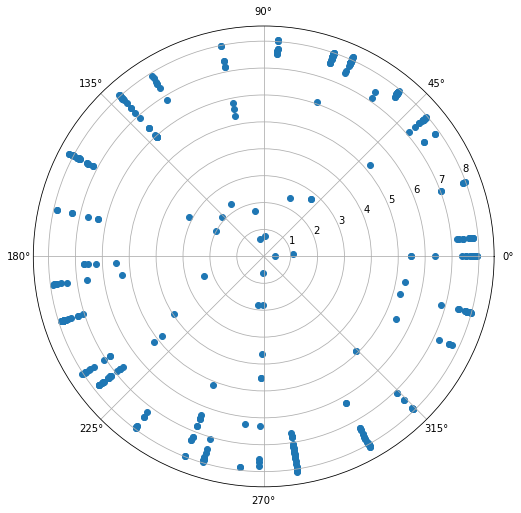

In [7]:
fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = plog.azi_bin
radii = plog.velocity
ax.scatter(theta, radii)

ValueError: x and y must have same first dimension, but have shapes (24,) and (0,)

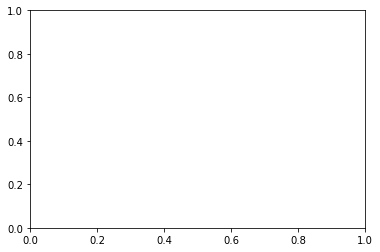

In [8]:
az_bins = np.linspace(0,360,25)
d=np.array(plog.distance)
t=np.array(plog.time)
p_vel = []
for i in range(len(az_bins)-1):
    min_az = az_bins[i]
    max_az = az_bins[i+1]
    ind = [j for j,az in enumerate(plog.azimuth) if (az > min_az) & (az < max_az)]
    if ind:
        dist = [d[j] for j in ind]
        tt = [t[j] for j in ind]
        #m,b = np.polyfit(np.array(tt),np.array(dist),1)
        #p_vel.append(m)
    #else:
        #p_vel.append(0)

fig,ax = plt.subplots(1,1)
ax.plot(az_bins[0:24],p_vel,'.')
ax.set_xlabel('Azimuth')
ax.set_ylabel('P-wave velocity')

Let's explore the azimuthal dependance of velocity with a plot of velocity vs azimuthal angle.

In [ ]:
fig = figure(figsize=(8,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
theta = log.azimuth
radii = log.velocity
ax.scatter(theta, radii)

#TODO rotate so North is up, add velocity and direction bins, fix velocity scale, add title legend etc

----- Random Experimentation Below, no reason to read past this point -----

In [ ]:
#replicating Maleen's plot, some code is copied and modified
p_log = log[log['phase'] == 'P']
s_log = log[log['phase'] == 'S']

fig,ax = plt.subplots(1,1,figsize=[10,10])
ax.plot(p_log['travel_time'],p_log['distance'],'.')
ax.plot(s_log['travel_time'],s_log['distance'],'.')
ax.set_xlabel('Travel time (s)')
ax.set_ylabel('Distance (km)')
ax.legend(['P-waves','S-waves'])

# P-wave fit
m,b = np.polyfit(p_log['travel_time'].tolist(),p_log['distance'].tolist(),1)
x_p = np.linspace(0,150)
ax.plot(x_p,x_p*m + b,'-')
print('P-wave slope is '+str(m)+' km/s.')

# S-wave fit
m,b = np.polyfit(s_log['travel_time'].tolist(),s_log['distance'].tolist(),1)
x_p = np.linspace(0,150)
ax.plot(x_p,x_p*m + b,'-')
print('S-wave slope is '+str(m)+' km/s.')